In [1]:
import os
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor

## Dataset from Kaggle (https://www.kaggle.com/omkargurav/face-mask-dataset)

In [2]:
data_dir = 'facemaskdetection/data'
dataset = ImageFolder(data_dir, transform=ToTensor())
print(len(dataset))
print(dataset.classes)

7553
['with_mask', 'without_mask']


Label:  with_mask (0)


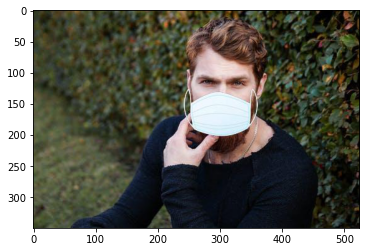

In [3]:
import torch
import matplotlib.pyplot as plt
%matplotlib inline

def show_example(img, label):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))  

show_example(*dataset[0])

### Resizing the image and cropping it to 32 * 32-pixel image, and also normalizing the pixel values to the mean and standard deviation of Imagenet images.

In [4]:
import torchvision.transforms as tt
image_size = (32,32)
stats = ([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
dataset = ImageFolder(data_dir, tt.Compose([
    tt.Resize(image_size),
    tt.ToTensor(),
    tt.Normalize(*stats)
]))

## Creating Training and Validation Sets

In [5]:
from torch.utils.data import random_split
val_pct = 0.1
val_size = int(val_pct * len(dataset))

train_ds, valid_ds = random_split(dataset, [len(dataset) - val_size, val_size])

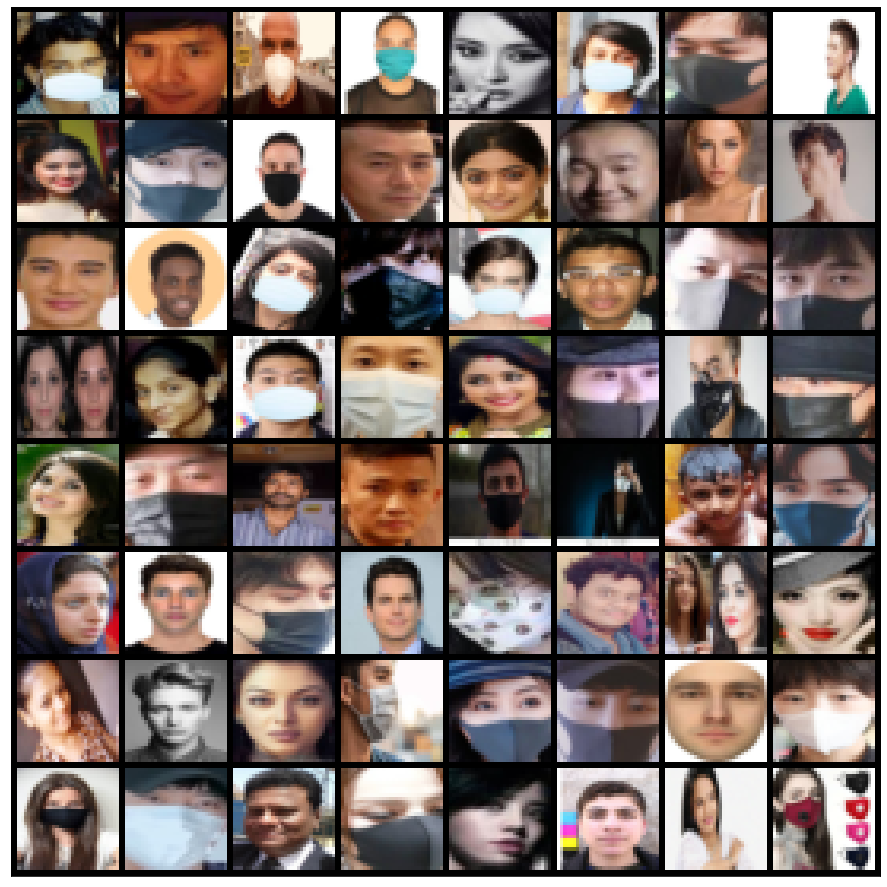

In [6]:
from torch.utils.data import DataLoader
batch_size = 256

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size*2, num_workers=4, pin_memory=True)

from torchvision.utils import make_grid
def denormalize(images, means, stds):
    if len(images.shape) == 3:
        images = images.unsqueeze(0)
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

def show_image(img_tensor, label):
    print('Label:', dataset.classes[label], '(' + str(label) + ')')
    img_tensor = denormalize(img_tensor, *stats)[0].permute((1, 2, 0))
    plt.imshow(img_tensor)

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(16, 16))
        ax.set_xticks([]); ax.set_yticks([])
        images = denormalize(images[:64], *stats)
        ax.imshow(make_grid(images, nrow=8).permute(1, 2, 0))
        break
show_batch(train_dl)

# Image Classification Base Class

In [7]:
import torch.nn as nn
import torch.nn.functional as F

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels)  # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}],{} train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, "last_lr: {:.5f},".format(result['lrs'][-1]) if 'lrs' in result else '', 
            result['train_loss'], result['val_loss'], result['val_acc']))

In [8]:
import torch
from tqdm.notebook import tqdm

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader,
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []

    # Set up custom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs,
                                                steps_per_epoch=len(train_loader))

    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            # Gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            optimizer.step()
            optimizer.zero_grad()

            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [9]:
class CnnModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            # input: 3*32*32
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            # output: 32*32*32
            nn.ReLU(),
            # output: 32*32*32
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            # output: 64*32*32
            nn.ReLU(),
            # output: 64*32*32
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(), 
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4
            nn.Flatten(), #flatten to vector of class 10
            nn.Linear(256*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10))
        
    def forward(self, xb):
        return self.network(xb)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

model = CnnModel().to(device)
model

Using cpu device


CnnModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=4096, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_features=10

In [15]:
# Transfer Learning using pre-trained ResNet34 model with weights from pre-training on ImageNet dataset.
from torchvision import models
models.resnet34(pretrained=True)


class MasksModel(ImageClassificationBase):

    def __init__(self, num_classes, pretrained=True):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet34(pretrained=pretrained) #downloading weights from this model when it was trained on ImageNet dataset
        # Replace last layer
        self.network.fc = nn.Linear(self.network.fc.in_features, num_classes)

    def forward(self, xb):
        return self.network(xb)

model = MasksModel(len(dataset.classes), pretrained=True)
model = model.to(device)
lr = nn.CrossEntropyLoss()

fit(2, 0.02, model, train_dl, valid_dl, opt_func=torch.optim.SGD)

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [0], train_loss: 1.4282, val_loss: 0.5964, val_acc: 0.6402


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [1], train_loss: 0.3396, val_loss: 0.3748, val_acc: 0.8416


[{'val_loss': 0.5963760614395142,
  'val_acc': 0.6402190923690796,
  'train_loss': 1.4282265901565552},
 {'val_loss': 0.3747602105140686,
  'val_acc': 0.8416280746459961,
  'train_loss': 0.33960723876953125}]

In [17]:
model2 = MasksModel(len(dataset.classes), pretrained=False)
model2 = model2.to(device)

fit_one_cycle(2, 0.02, model2, train_dl, valid_dl)

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [0],last_lr: 0.01623, train_loss: 0.6056, val_loss: 7.1725, val_acc: 0.6926


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [1],last_lr: 0.00000, train_loss: 0.2702, val_loss: 0.2744, val_acc: 0.8859


[{'val_loss': 7.172475814819336,
  'val_acc': 0.6925677061080933,
  'train_loss': 0.6055705547332764,
  'lrs': [0.0007999999999999986,
   0.0010043182848573952,
   0.0016085760641114492,
   0.0025870523142061293,
   0.0038980969123928837,
   0.005485903528739828,
   0.007282885095635036,
   0.009212550739814262,
   0.01119276171653439,
   0.01313922775279141,
   0.014969094973155905,
   0.016604472683465033,
   0.017975748890205378,
   0.019024553426162997,
   0.01970624255301757,
   0.01999179928051809,
   0.019977904471766315,
   0.019888308709018237,
   0.019730449784003415,
   0.01950541746781633,
   0.0192147652596556,
   0.018860499662320927,
   0.018445066330422637,
   0.017971333186928933,
   0.017442570624604938,
   0.016862428929021823,
   0.01623491307899526]},
 {'val_loss': 0.2744099497795105,
  'val_acc': 0.8858506679534912,
  'train_loss': 0.27024662494659424,
  'lrs': [0.015564355098416988,
   0.014855384150347234,
   0.01411289457982199,
   0.013342012125989898,
   0.01

In [40]:
import matplotlib.pyplot as plt
import numpy as np
from torch import nn, optim
from torch.autograd import Variable


def test_network(net, trainloader):

    criterion = nn.MSELoss()
    optimizer = optim.Adam(net.parameters(), lr=0.001)

    dataiter = iter(trainloader)
    images, labels = dataiter.next()

    # Create Variables for the inputs and targets
    inputs = Variable(images)
    targets = Variable(images)

    # Clear the gradients from all Variables
    optimizer.zero_grad()

    # Forward pass, then backward pass, then update weights
    output = net.forward(inputs)
    loss = criterion(output, targets)
    loss.backward()
    optimizer.step()

    return True


def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax


def view_recon(img, recon):
    ''' Function for displaying an image (as a PyTorch Tensor) and its
        reconstruction also a PyTorch Tensor
    '''

    fig, axes = plt.subplots(ncols=2, sharex=True, sharey=True)
    axes[0].imshow(img.numpy().squeeze())
    axes[1].imshow(recon.data.numpy().squeeze())
    for ax in axes:
        ax.axis('off')
        ax.set_adjustable('box-forced')

def view_classify(img, ps, version="MNIST"):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    if version == "MNIST":
        ax2.set_yticklabels(np.arange(10))
    elif version == "Fashion":
        ax2.set_yticklabels(['T-shirt/top',
                            'Trouser',
                            'Pullover',
                            'Dress',
                            'Coat',
                            'Sandal',
                            'Shirt',
                            'Sneaker',
                            'Bag',
                            'Ankle Boot'], size='small');
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

# Handwritten digits

In [23]:
# Import necessary packages

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import torch
import matplotlib.pyplot as plt

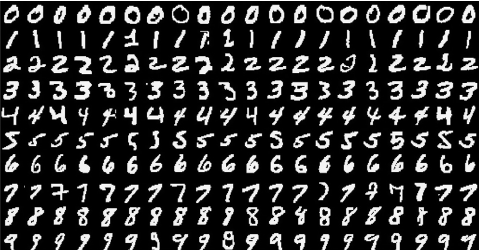

In [24]:
from six.moves import urllib
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

In [25]:
### Download dataset from Torchvision package
from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])
# Download and load the training data
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

0it [00:00, ?it/s]

Extracting /Users/yiheng/.pytorch/MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to /Users/yiheng/.pytorch/MNIST_data/MNIST/raw


0it [00:00, ?it/s]

Extracting /Users/yiheng/.pytorch/MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to /Users/yiheng/.pytorch/MNIST_data/MNIST/raw


0it [00:00, ?it/s]

Extracting /Users/yiheng/.pytorch/MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to /Users/yiheng/.pytorch/MNIST_data/MNIST/raw


0it [00:00, ?it/s]

Extracting /Users/yiheng/.pytorch/MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /Users/yiheng/.pytorch/MNIST_data/MNIST/raw
Processing...
Done!


/opt/anaconda3/lib/python3.8/site-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /tmp/pip-req-build-7w1l4mea/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


We have the training data loaded into trainloader and we make that an iterator with iter(trainloader). Later, we'll use this to loop through the dataset for training, like

for image, label in trainloader:
    do things with images and labels
    
   
You'll notice I created the trainloader with a batch size of 64, and shuffle=True. 
# The batch size
is the number of images we get in one iteration from the data loader and pass through our network, often called a batch. And shuffle=True tells it to shuffle the dataset every time we start going through the data loader again. 
But here I'm just grabbing the first batch so we can check out the data. We can see below that images is just a tensor with size (64, 1, 28, 28). 
# 64 images per batch, 1 color channel, and 28x28 images.

In [26]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
print(type(images))
print(images.shape)
print(labels.shape)

<class 'torch.Tensor'>
torch.Size([64, 1, 28, 28])
torch.Size([64])


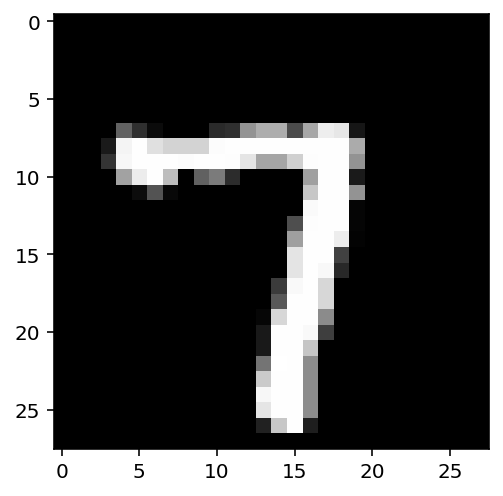

In [27]:
plt.imshow(images[1].numpy().squeeze(), cmap='Greys_r');

Fully-connected or dense networks. Each unit in one layer is connected to each unit in the next layer.
Input layer must be 1D vector
Images are 28X28 2D tensors -> convert into 1D vectors

# Flattening
(64,1,28,28) -> (64,784)

In [28]:
def activation(x):
    return 1/(1+torch.exp(-x))

# Flatten the input images
inputs = images.view(images.shape[0], -1)

# Create parameters
w1 = torch.randn(784, 256)
b1 = torch.randn(256)

w2 = torch.randn(256, 10)
b2 = torch.randn(10)

h = activation(torch.mm(inputs, w1) + b1)

out = activation(torch.mm(h, w2) + b2)

In [29]:
# 10 outputs for 10 digits. Each class has a probability
# Softmax function is used 
# Softmax shrinks each input between 0 and 1 and normalizes the values to give you a proper probability distribution where the probabilites sum up to one.

# Building the neural network

In [30]:
from torch import nn
#784 inputs, 256 hidden, 10 outputs and 1 softmax output
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Inputs to hidden layer linear transformation
        self.hidden = nn.Linear(784, 256)
        # Output layer, 10 units - one for each digit
        self.output = nn.Linear(256, 10)
        
        # Define sigmoid activation and softmax output 
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        # Pass the input tensor through each of our operations
        x = self.hidden(x)
        x = self.sigmoid(x)
        x = self.output(x)
        x = self.softmax(x)
        
        return x

1. class Network(nn.Module):

Here we're inheriting from nn.Module. Combined with super().__init__() this creates a class that tracks the architecture and provides a lot of useful methods and attributes. It is mandatory to inherit from nn.Module when you're creating a class for your network. The name of the class itself can be anything.

2. self.hidden = nn.Linear(784, 256)

This line creates a module for a linear transformation, , with 784 inputs and 256 outputs and assigns it to self.hidden. The module automatically creates the weight and bias tensors which we'll use in the forward method. You can access the weight and bias tensors once the network (net) is created with net.hidden.weight and net.hidden.bias.

3. self.output = nn.Linear(256, 10)

Similarly, this creates another linear transformation with 256 inputs and 10 outputs. (hidden layer)

4. self.sigmoid = nn.Sigmoid(), self.softmax = nn.Softmax(dim=1)

Operations for the sigmoid activation and softmax output. Setting dim=1 in nn.Softmax(dim=1) calculates softmax across the columns.

5. def forward(self, x):

PyTorch networks created with nn.Module must have a forward method defined. It takes in a tensor x and passes it through the operations you defined in the __init__ method.

x = self.hidden(x)
x = self.sigmoid(x)
x = self.output(x)
x = self.softmax(x)
Here the input tensor x is passed through each operation a reassigned to x. We can see that the input tensor goes through the hidden layer, then a sigmoid function, then the output layer, and finally the softmax function. It doesn't matter what you name the variables here, as long as the inputs and outputs of the operations match the network architecture you want to build. The order in which you define things in the __init__ method doesn't matter, but you'll need to sequence the operations correctly in the forward method.

In [33]:
model = Network()
model

Network(
  (hidden): Linear(in_features=784, out_features=256, bias=True)
  (output): Linear(in_features=256, out_features=10, bias=True)
  (sigmoid): Sigmoid()
  (softmax): Softmax(dim=1)
)

In [34]:
# More concise way
import torch.nn.functional as F

class Network(nn.Module):
    def __init__(self):
        super().__init__()
        # Inputs to hidden layer linear transformation
        self.hidden = nn.Linear(784, 256)
        # Output layer, 10 units - one for each digit
        self.output = nn.Linear(256, 10)
        
    def forward(self, x):
        # Hidden layer with sigmoid activation
        x = F.sigmoid(self.hidden(x))
        # Output layer with softmax activation
        x = F.softmax(self.output(x), dim=1)
        
        return x

# Activation functions

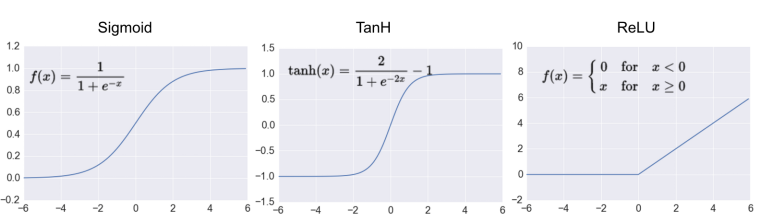

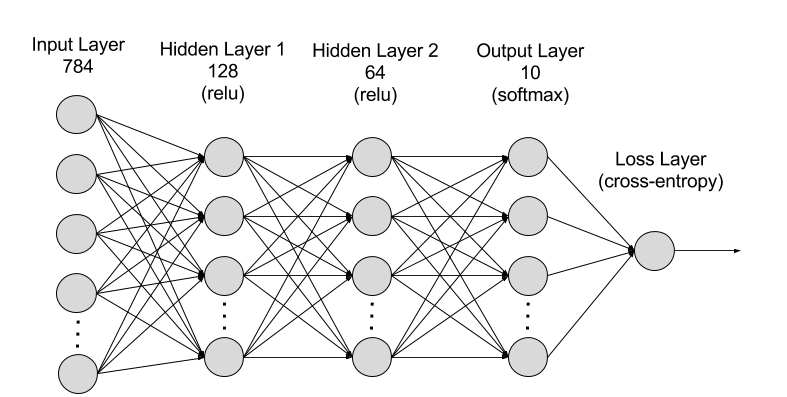

In [35]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        # Defining the layers, 128, 64, 10 units each
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, 64)
        # Output layer, 10 units - one for each digit
        self.fc3 = nn.Linear(64, 10)
        
    def forward(self, x):
        ''' Forward pass through the network, returns the output logits '''
        
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.softmax(x, dim=1)
        
        return x

model = Network()
model

Network(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)

# initialize weights and bias


In [36]:
print(model.fc1.weight)
print(model.fc1.bias)

Parameter containing:
tensor([[-0.0016,  0.0135, -0.0206,  ..., -0.0078,  0.0243,  0.0121],
        [ 0.0183,  0.0125,  0.0186,  ..., -0.0339,  0.0281,  0.0064],
        [-0.0163, -0.0253,  0.0257,  ..., -0.0021,  0.0353, -0.0081],
        ...,
        [ 0.0210, -0.0345,  0.0218,  ..., -0.0007,  0.0254, -0.0159],
        [-0.0018, -0.0067, -0.0229,  ..., -0.0335, -0.0322,  0.0091],
        [-0.0033,  0.0205, -0.0221,  ...,  0.0240, -0.0259,  0.0247]],
       requires_grad=True)
Parameter containing:
tensor([ 0.0151, -0.0226,  0.0129,  0.0130,  0.0279, -0.0129, -0.0025, -0.0313,
         0.0318, -0.0108,  0.0325,  0.0018,  0.0171, -0.0188,  0.0283, -0.0079,
         0.0044,  0.0028,  0.0093, -0.0118,  0.0236, -0.0125,  0.0047,  0.0152,
         0.0176, -0.0202, -0.0168, -0.0195,  0.0049,  0.0353,  0.0302, -0.0219,
         0.0225, -0.0306,  0.0258, -0.0187,  0.0242, -0.0019,  0.0134,  0.0115,
        -0.0313,  0.0054,  0.0255, -0.0227, -0.0244, -0.0208, -0.0150, -0.0318,
        -0.0156

In [37]:
# Set biases to all zeros
model.fc1.bias.data.fill_(0)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.])

In [38]:
# sample from random normal with standard dev = 0.01
model.fc1.weight.data.normal_(std=0.01)

tensor([[ 0.0128, -0.0022, -0.0011,  ..., -0.0010,  0.0006, -0.0107],
        [-0.0004, -0.0104,  0.0104,  ..., -0.0129,  0.0138, -0.0028],
        [ 0.0077, -0.0140, -0.0104,  ..., -0.0050, -0.0018,  0.0111],
        ...,
        [-0.0136,  0.0008, -0.0197,  ..., -0.0058, -0.0042,  0.0034],
        [ 0.0010,  0.0031,  0.0156,  ..., -0.0019,  0.0066,  0.0047],
        [ 0.0249, -0.0080, -0.0127,  ..., -0.0084, -0.0146, -0.0098]])

# nn.Sequential

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
  (5): Softmax(dim=1)
)


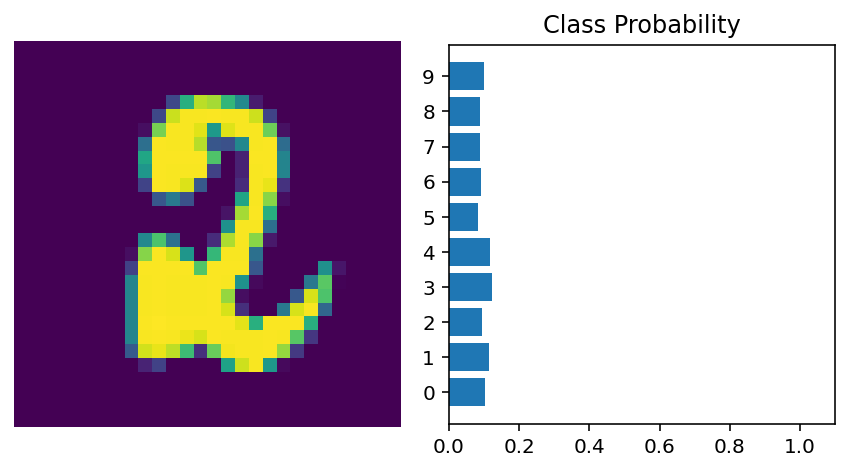

In [41]:
# Hyperparameters for our network
input_size = 784
hidden_sizes = [128, 64]
output_size = 10

# Build a feed-forward network
model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[1], output_size),
                      nn.Softmax(dim=1))
print(model)

# Forward pass through the network and display output
images, labels = next(iter(trainloader))
images.resize_(images.shape[0], 1, 784)
ps = model.forward(images[0,:])
view_classify(images[0].view(1, 28, 28), ps)

In [42]:
#Operations are available by passing in the appropriate index. First linear operation and look at weights -> model[0]


In [44]:
print(model[0])
model[0].weight

Linear(in_features=784, out_features=128, bias=True)


Parameter containing:
tensor([[ 0.0253,  0.0216,  0.0209,  ..., -0.0187, -0.0047,  0.0219],
        [-0.0291,  0.0161, -0.0253,  ...,  0.0298, -0.0039,  0.0170],
        [-0.0156, -0.0271, -0.0073,  ...,  0.0182, -0.0159, -0.0038],
        ...,
        [ 0.0109, -0.0163,  0.0080,  ...,  0.0306, -0.0298, -0.0079],
        [ 0.0149,  0.0334, -0.0229,  ..., -0.0333, -0.0088,  0.0233],
        [-0.0135,  0.0241, -0.0171,  ..., -0.0217, -0.0115,  0.0267]],
       requires_grad=True)

OrderedDict to name individual layers and operations instead of using cremental integers. each operation must have a different name

In [45]:
from collections import OrderedDict
model = nn.Sequential(OrderedDict([
                      ('fc1', nn.Linear(input_size, hidden_sizes[0])),
                      ('relu1', nn.ReLU()),
                      ('fc2', nn.Linear(hidden_sizes[0], hidden_sizes[1])),
                      ('relu2', nn.ReLU()),
                      ('output', nn.Linear(hidden_sizes[1], output_size)),
                      ('softmax', nn.Softmax(dim=1))]))
model

Sequential(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (relu2): ReLU()
  (output): Linear(in_features=64, out_features=10, bias=True)
  (softmax): Softmax(dim=1)
)

In [46]:
print(model[0])
print(model.fc1)

Linear(in_features=784, out_features=128, bias=True)
Linear(in_features=784, out_features=128, bias=True)


# Train Neural Network 
adjust network parameters using the loss function. By minimizing this loss with respect to the network parameters, we can find configurations where the loss is at a minimum and the network is able to predict the correct labels with high accuracy. We find this minimum using a process called gradient descent. The gradient is the slope of the loss function and points in the direction of fastest change. To get to the minimum in the least amount of time, we then want to follow the gradient (downwards). You can think of this like descending a mountain by following the steepest slope to the base.

# Backpropagation
in the forward pass through the network, data and operation go from bottom to top. We pass the input x throught a linear transformation L1 with weights W1 and biases b1. Output goes through the sigmoid operation S and another linear transformation L2. we calculate the loss l and use the loss as a measure of how bad the network's predictions are. The goal is to adjust the weights and biases to minimize the loss

To train the weights with gradient descent, we propagate the gradient of the loss backwards through the network. Each operation has some gradient between the inputs and outputs. As we send the gradients backwards, we multiply the incoming gradient with the gradient for the operation. Mathematically, this is really just calculating the gradient of the loss with respect to the weights using the chain rule.

we update our weights using this gradient with some learning rate

the learning rate is set such that the weight update steps are small enough that the iterative methods settles in a minimum
 


# Losses in PyTorch
using nn module, PyTorch provides losses such as the cross-entropy loss (nn.CrossEntropyLoss). You'll usually see the loss assigned to criterion. As noted in the last part, with a classification problem such as MNIST, we're using the softmax function to predict class probabilities. With a softmax output, you want to use cross-entropy as the loss. To actually calculate the loss, you first define the criterion then pass in the output of your network and the correct labels.

Something really important to note here. Looking at the documentation for nn.CrossEntropyLoss,

This criterion combines nn.LogSoftmax() and nn.NLLLoss() in one single class.

The input is expected to contain scores for each class.

This means we need to pass in the raw output of our network into the loss, not the output of the softmax function. This raw output is usually called the logits or scores. We use the logits because softmax gives you probabilities which will often be very close to zero or one but floating-point numbers can't accurately represent values near zero or one (read more here). It's usually best to avoid doing calculations with probabilities, typically we use log-probabilities.

In [47]:
# Build a feed-forward network
model = nn.Sequential(nn.Linear(784, 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64, 10))

# Define the loss
criterion = nn.CrossEntropyLoss()

# Get our data
images, labels = next(iter(trainloader))
# Flatten images
images = images.view(images.shape[0], -1)

# Forward pass, get our logits
logits = model(images)
# Calculate the loss with the logits and the labels
loss = criterion(logits, labels)

print(loss)

tensor(2.3013, grad_fn=<NllLossBackward>)


In [48]:
# Build a feed-forward network
model = nn.Sequential(nn.Linear(784, 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64, 10),
                      nn.LogSoftmax(dim=1))

# Define the loss
criterion = nn.NLLLoss()

# Get our data
images, labels = next(iter(trainloader))
# Flatten images
images = images.view(images.shape[0], -1)

# Forward pass, get our log-probabilities
logps = model(images)
# Calculate the loss with the logps and the labels
loss = criterion(logps, labels)

print(loss)

tensor(2.3349, grad_fn=<NllLossBackward>)


# Autograd

To perform backpropagation, autograd is used to automatically calculate the gradients of tensors. We use it to calculate the gradients of all our paremeters with respect to the loss. Autograd works by keeping track of operations performed on tensors, then going backwards through those operations, calculating gradients along the way.

set requires_grad = True

In [49]:
# Build a feed-forward network
model = nn.Sequential(nn.Linear(784, 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64, 10),
                      nn.LogSoftmax(dim=1))

criterion = nn.NLLLoss()
images, labels = next(iter(trainloader))
images = images.view(images.shape[0], -1)

logps = model(images)
loss = criterion(logps, labels)

In [50]:
print('Before backward pass: \n', model[0].weight.grad)

loss.backward()

print('After backward pass: \n', model[0].weight.grad)

Before backward pass: 
 None
After backward pass: 
 tensor([[-0.0018, -0.0018, -0.0018,  ..., -0.0018, -0.0018, -0.0018],
        [ 0.0007,  0.0007,  0.0007,  ...,  0.0007,  0.0007,  0.0007],
        [ 0.0006,  0.0006,  0.0006,  ...,  0.0006,  0.0006,  0.0006],
        ...,
        [ 0.0019,  0.0019,  0.0019,  ...,  0.0019,  0.0019,  0.0019],
        [ 0.0007,  0.0007,  0.0007,  ...,  0.0007,  0.0007,  0.0007],
        [ 0.0018,  0.0018,  0.0018,  ...,  0.0018,  0.0018,  0.0018]])


# Training
Optimizer is used to update the weights with the gradients. using optim package. use stochastic gradient descent with optim.SGD

The general process with PyTorch:

1. Make a forward pass through the network
2. Use the network output to calculate the loss
3. Perform a backward pass through the network with loss.backward() to calculate the gradients
4. Take a step with the optimizer to update the weights

In [51]:
model = nn.Sequential(nn.Linear(784, 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64, 10),
                      nn.LogSoftmax(dim=1))

criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.003)

epochs = 5
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        # Flatten MNIST images into a 784 long vector
        images = images.view(images.shape[0], -1)
    
        # TODO: Training pass
        optimizer.zero_grad()
        
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    else:
        print(f"Training loss: {running_loss/len(trainloader)}")

Training loss: 1.889019810822981
Training loss: 0.8389647051151882
Training loss: 0.5331791710497727
Training loss: 0.4328488171863149
Training loss: 0.38549583972390017


tensor([[6.4120e-05, 1.6236e-08, 1.1806e-03, 6.3525e-08, 1.3874e-03, 1.8123e-05,
         9.9729e-01, 3.9020e-08, 3.1403e-05, 2.5869e-05]],
       grad_fn=<ExpBackward>)


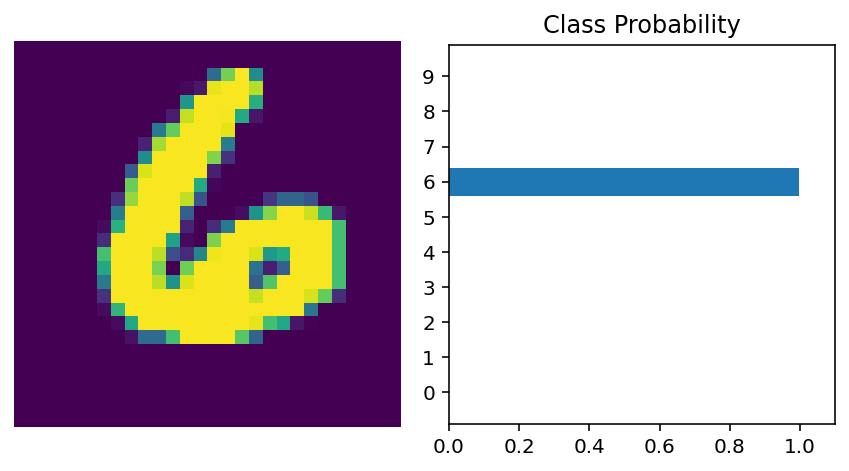

In [55]:
%matplotlib inline
images, labels = next(iter(trainloader))

img = images[0].view(1, 784)
# Turn off gradients to speed up this part
with torch.no_grad():
    logps = model(img)

# Output of the network are log-probabilities, need to take exponential for probabilities
ps = torch.exp(logps)
view_classify(img.view(1, 28, 28), ps)

# Fashion MNIST Dataset


In [56]:
import torch
from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
# Download and load the training data
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

0it [00:00, ?it/s]

Extracting /Users/yiheng/.pytorch/F_MNIST_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to /Users/yiheng/.pytorch/F_MNIST_data/FashionMNIST/raw


0it [00:00, ?it/s]

Extracting /Users/yiheng/.pytorch/F_MNIST_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /Users/yiheng/.pytorch/F_MNIST_data/FashionMNIST/raw


0it [00:00, ?it/s]

Extracting /Users/yiheng/.pytorch/F_MNIST_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /Users/yiheng/.pytorch/F_MNIST_data/FashionMNIST/raw


0it [00:00, ?it/s]

Extracting /Users/yiheng/.pytorch/F_MNIST_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /Users/yiheng/.pytorch/F_MNIST_data/FashionMNIST/raw
Processing...
Done!


<AxesSubplot:>

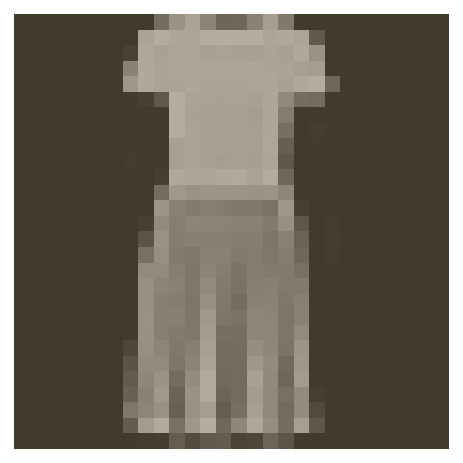

In [57]:
image, label = next(iter(trainloader))
imshow(image[0,:])

In [59]:
from torch import nn, optim
import torch.nn.functional as F

class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        
    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.log_softmax(self.fc4(x), dim=1)
        
        return x

In [60]:
model = Classifier()
# define loss function 
criterion = nn.NLLLoss()
# define optimizer (algorithms to change the attributes of neural network, weights and learning rate to reduce losses)
optimizer = optim.Adam(model.parameters(), lr=0.003)

In [61]:
epochs = 5

for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        #prediction and loss
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        #backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    else:
        print(f"Training loss: {running_loss/len(trainloader)}")

Training loss: 0.511783086494215
Training loss: 0.3943522836782658
Training loss: 0.3575715106576363
Training loss: 0.3335020948193475
Training loss: 0.3182167223235692


tensor([[9.8436e-01, 3.8017e-06, 1.8051e-03, 4.9699e-03, 5.0280e-06, 1.4314e-07,
         8.8535e-03, 3.5648e-11, 2.0200e-06, 9.7464e-09]],
       grad_fn=<ExpBackward>)


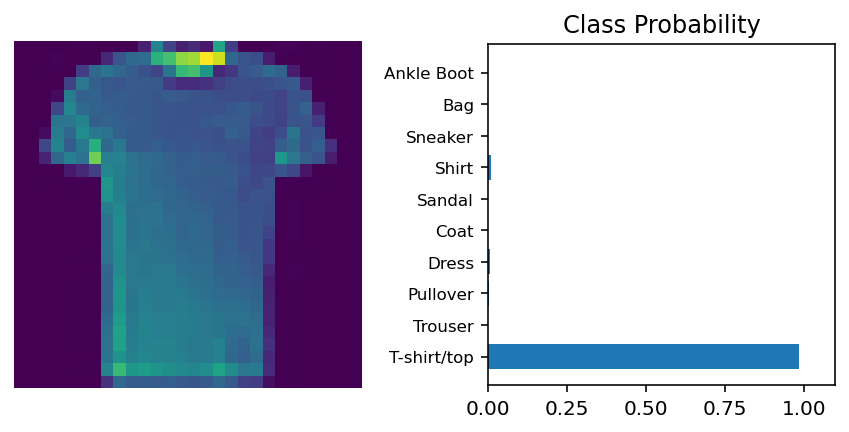

In [63]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

dataiter = iter(testloader)
images, labels = dataiter.next()
img = images[1]

ps = torch.exp(model(img))
print(ps)
# Plot the image and probabilities
view_classify(img, ps, version='Fashion')

In [68]:
model = Classifier()
criterion = nn.NLLLoss(reduction='sum')
optimizer = optim.Adam(model.parameters(), lr=0.003)

epochs = 30

train_losses, test_losses = [], []
for e in range(epochs):
    tot_train_loss = 0
    for images, labels in trainloader:
        optimizer.zero_grad()
        
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        tot_train_loss += loss.item()
        
        loss.backward()
        optimizer.step()
    else:
        tot_test_loss = 0
        test_correct = 0  # Number of correct predictions on the test set
        
        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
            for images, labels in testloader:
                log_ps = model(images)
                loss = criterion(log_ps, labels)
                tot_test_loss += loss.item()

                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                test_correct += equals.sum().item()

        # Get mean loss to enable comparison between train and test sets
        train_loss = tot_train_loss / len(trainloader.dataset)
        test_loss = tot_test_loss / len(testloader.dataset)

        # At completion of epoch
        train_losses.append(train_loss)
        test_losses.append(test_loss)

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(train_loss),
              "Test Loss: {:.3f}.. ".format(test_loss),
              "Test Accuracy: {:.3f}".format(test_correct / len(testloader.dataset)))

Epoch: 1/30..  Training Loss: 0.517..  Test Loss: 0.442..  Test Accuracy: 0.842
Epoch: 2/30..  Training Loss: 0.392..  Test Loss: 0.402..  Test Accuracy: 0.852
Epoch: 3/30..  Training Loss: 0.353..  Test Loss: 0.388..  Test Accuracy: 0.862
Epoch: 4/30..  Training Loss: 0.332..  Test Loss: 0.379..  Test Accuracy: 0.864
Epoch: 5/30..  Training Loss: 0.316..  Test Loss: 0.387..  Test Accuracy: 0.862
Epoch: 6/30..  Training Loss: 0.303..  Test Loss: 0.382..  Test Accuracy: 0.867
Epoch: 7/30..  Training Loss: 0.291..  Test Loss: 0.364..  Test Accuracy: 0.875
Epoch: 8/30..  Training Loss: 0.283..  Test Loss: 0.351..  Test Accuracy: 0.879
Epoch: 9/30..  Training Loss: 0.274..  Test Loss: 0.358..  Test Accuracy: 0.872
Epoch: 10/30..  Training Loss: 0.267..  Test Loss: 0.393..  Test Accuracy: 0.867
Epoch: 11/30..  Training Loss: 0.258..  Test Loss: 0.373..  Test Accuracy: 0.876
Epoch: 12/30..  Training Loss: 0.257..  Test Loss: 0.377..  Test Accuracy: 0.879
Epoch: 13/30..  Training Loss: 0.247.

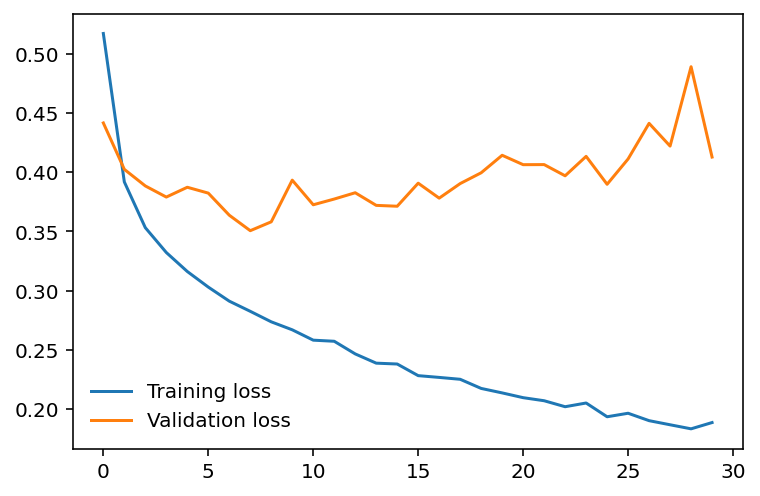

In [69]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

# Overfitting
Network learns the training set better and better, resulting in lower training losses. However, it data outside the training set results in validation loss increasing. ultimate goal of deep learning model is to make predictions on new data, we should strive to get the lowest validation loss possible.

1. Early Stopping (save model with lowest validation loss)
2. Dropout (randomly drop input units to force network to share information between weights, increasing its ability to generalize to new data)

During training we use dropout to prevent overfitting
During inference we use entire network, turn off fropout during validation, testing and making predictions
model.eval() -> dropout probability is zero

In [70]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)

        # Dropout module with 0.2 drop probability
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)

        # Now with dropout
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))

        # output so no dropout here
        x = F.log_softmax(self.fc4(x), dim=1)

        return x

In [71]:
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

epochs = 30
steps = 0

train_losses, test_losses = [], []
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        
        optimizer.zero_grad()
        
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    else:
        test_loss = 0
        accuracy = 0
        
        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
            model.eval()
            for images, labels in testloader:
                log_ps = model(images)
                test_loss += criterion(log_ps, labels)
                
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
        
        model.train()
        
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(train_losses[-1]),
              "Test Loss: {:.3f}.. ".format(test_losses[-1]),
              "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))

Epoch: 1/30..  Training Loss: 0.605..  Test Loss: 0.520..  Test Accuracy: 0.816
Epoch: 2/30..  Training Loss: 0.485..  Test Loss: 0.432..  Test Accuracy: 0.838
Epoch: 3/30..  Training Loss: 0.450..  Test Loss: 0.456..  Test Accuracy: 0.841
Epoch: 4/30..  Training Loss: 0.438..  Test Loss: 0.407..  Test Accuracy: 0.850
Epoch: 5/30..  Training Loss: 0.424..  Test Loss: 0.401..  Test Accuracy: 0.861
Epoch: 6/30..  Training Loss: 0.411..  Test Loss: 0.402..  Test Accuracy: 0.861
Epoch: 7/30..  Training Loss: 0.402..  Test Loss: 0.408..  Test Accuracy: 0.860
Epoch: 8/30..  Training Loss: 0.398..  Test Loss: 0.411..  Test Accuracy: 0.847
Epoch: 9/30..  Training Loss: 0.391..  Test Loss: 0.404..  Test Accuracy: 0.857
Epoch: 10/30..  Training Loss: 0.389..  Test Loss: 0.385..  Test Accuracy: 0.856
Epoch: 11/30..  Training Loss: 0.384..  Test Loss: 0.394..  Test Accuracy: 0.861
Epoch: 12/30..  Training Loss: 0.380..  Test Loss: 0.373..  Test Accuracy: 0.868
Epoch: 13/30..  Training Loss: 0.379.

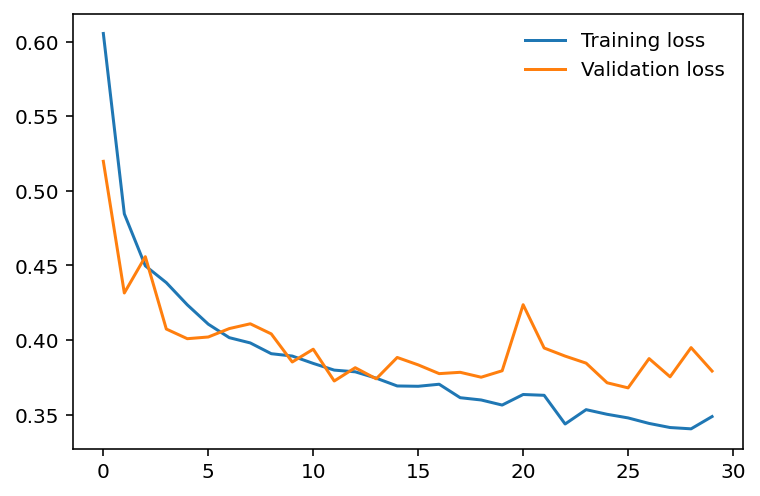

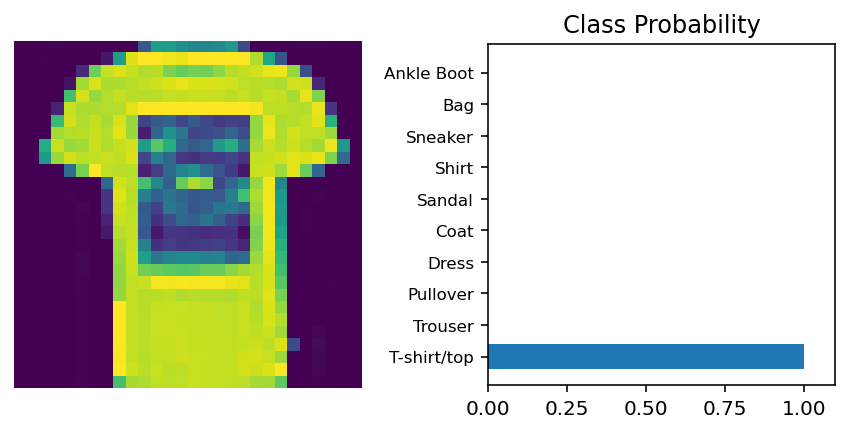

In [72]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

model.eval()

dataiter = iter(testloader)
images, labels = dataiter.next()
img = images[0]
# Convert 2D image to 1D vector
img = img.view(1, 784)

# Calculate the class probabilities (softmax) for img
with torch.no_grad():
    output = model.forward(img)

ps = torch.exp(output)

# Plot the image and probabilities
view_classify(img.view(1, 28, 28), ps, version='Fashion')

In [73]:
print("Our model: \n\n", model, '\n')
print("The state dict keys: \n\n", model.state_dict().keys())

Our model: 

 Classifier(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
) 

The state dict keys: 

 odict_keys(['fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'fc3.weight', 'fc3.bias', 'fc4.weight', 'fc4.bias'])


# Saving the Model

In [76]:
# Parameters for networks are stored in state_dict (contains the weights and bias matrices for each layers)
torch.save(model.state_dict(), 'checkpoint.pth')

# load the state dict then load it to the network
# works if the model architecture exactly the same as the checkpoint architecture
state_dict = torch.load('checkpoint.pth')
print(state_dict.keys())
model.load_state_dict(state_dict)


odict_keys(['fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'fc3.weight', 'fc3.bias', 'fc4.weight', 'fc4.bias'])


<All keys matched successfully>

In [77]:
import torch
from torch import nn
import torch.nn.functional as F


class Network(nn.Module):
    def __init__(self, input_size, output_size, hidden_layers, drop_p=0.5):
        ''' Builds a feedforward network with arbitrary hidden layers.
        
            Arguments
            ---------
            input_size: integer, size of the input layer
            output_size: integer, size of the output layer
            hidden_layers: list of integers, the sizes of the hidden layers
        
        '''
        super().__init__()
        # Input to a hidden layer
        self.hidden_layers = nn.ModuleList([nn.Linear(input_size, hidden_layers[0])])
        
        # Add a variable number of more hidden layers
        layer_sizes = zip(hidden_layers[:-1], hidden_layers[1:])
        self.hidden_layers.extend([nn.Linear(h1, h2) for h1, h2 in layer_sizes])
        
        self.output = nn.Linear(hidden_layers[-1], output_size)
        
        self.dropout = nn.Dropout(p=drop_p)
        
    def forward(self, x):
        ''' Forward pass through the network, returns the output logits '''
        
        for each in self.hidden_layers:
            x = F.relu(each(x))
            x = self.dropout(x)
        x = self.output(x)
        
        return F.log_softmax(x, dim=1)


def validation(model, testloader, criterion):
    accuracy = 0
    test_loss = 0
    for images, labels in testloader:

        images = images.resize_(images.size()[0], 784)

        output = model.forward(images)
        test_loss += criterion(output, labels).item()

        ## Calculating the accuracy 
        # Model's output is log-softmax, take exponential to get the probabilities
        ps = torch.exp(output)
        # Class with highest probability is our predicted class, compare with true label
        equality = (labels.data == ps.max(1)[1])
        # Accuracy is number of correct predictions divided by all predictions, just take the mean
        accuracy += equality.type_as(torch.FloatTensor()).mean()

    return test_loss, accuracy


def train(model, trainloader, testloader, criterion, optimizer, epochs=5, print_every=40):
    
    steps = 0
    running_loss = 0
    for e in range(epochs):
        # Model in training mode, dropout is on
        model.train()
        for images, labels in trainloader:
            steps += 1
            
            # Flatten images into a 784 long vector
            images.resize_(images.size()[0], 784)
            
            optimizer.zero_grad()
            
            output = model.forward(images)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()

            if steps % print_every == 0:
                # Model in inference mode, dropout is off
                model.eval()
                
                # Turn off gradients for validation, will speed up inference
                with torch.no_grad():
                    test_loss, accuracy = validation(model, testloader, criterion)
                
                print("Epoch: {}/{}.. ".format(e+1, epochs),
                      "Training Loss: {:.3f}.. ".format(running_loss/print_every),
                      "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
                      "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))
                
                running_loss = 0
                
                # Make sure dropout and grads are on for training
                model.train()

In [78]:
model = Network(784, 10, [512, 256, 128])
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
train(model, trainloader, testloader, criterion, optimizer, epochs=2)


Epoch: 1/2..  Training Loss: 1.716..  Test Loss: 1.030..  Test Accuracy: 0.656
Epoch: 1/2..  Training Loss: 1.087..  Test Loss: 0.765..  Test Accuracy: 0.705
Epoch: 1/2..  Training Loss: 0.851..  Test Loss: 0.665..  Test Accuracy: 0.747
Epoch: 1/2..  Training Loss: 0.766..  Test Loss: 0.671..  Test Accuracy: 0.746
Epoch: 1/2..  Training Loss: 0.767..  Test Loss: 0.637..  Test Accuracy: 0.748
Epoch: 1/2..  Training Loss: 0.764..  Test Loss: 0.609..  Test Accuracy: 0.769
Epoch: 1/2..  Training Loss: 0.694..  Test Loss: 0.587..  Test Accuracy: 0.774
Epoch: 1/2..  Training Loss: 0.670..  Test Loss: 0.593..  Test Accuracy: 0.771
Epoch: 1/2..  Training Loss: 0.680..  Test Loss: 0.566..  Test Accuracy: 0.789
Epoch: 1/2..  Training Loss: 0.643..  Test Loss: 0.542..  Test Accuracy: 0.793
Epoch: 1/2..  Training Loss: 0.644..  Test Loss: 0.544..  Test Accuracy: 0.795
Epoch: 1/2..  Training Loss: 0.674..  Test Loss: 0.547..  Test Accuracy: 0.798
Epoch: 1/2..  Training Loss: 0.614..  Test Loss: 0.5

In [79]:
# better to save the model architecture and the state dict
checkpoint = {'input_size': 784,
              'output_size': 10,
              'hidden_layers': [each.out_features for each in model.hidden_layers],
              'state_dict': model.state_dict()}

torch.save(checkpoint, 'checkpoint.pth')

In [81]:
# Load and rebuild trained model
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = Network(checkpoint['input_size'],
                             checkpoint['output_size'],
                             checkpoint['hidden_layers'])
    model.load_state_dict(checkpoint['state_dict'])
    
    return model
model = load_checkpoint('checkpoint.pth')
print(model)

Network(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=256, bias=True)
    (2): Linear(in_features=256, out_features=128, bias=True)
  )
  (output): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


# Using Image Data
load image data using datasets.ImageFolder from torchvision

dataset = datasets.ImageFolder('path/to/data', transform = transform)

# Transforms
Ensure images are of the same size -> transforms.Resize()
transforms.CenterCrop()
transforms.RandomResizedCrop()
then convert images to PyTorch tensors with transforms.ToTensors()
can use compose to run them in sequence

# Data Loaders
Takes dataset and returns batches of images and corresponding labels

# Data Augmentation
A common strategy for training neural networks is to introduce randomness in the input data itself. For example, you can randomly rotate, mirror, scale, and/or crop your images during training. This will help your network generalize as it's seeing the same images but in different locations, with different sizes, in different orientations, etc.

To randomly rotate, scale and crop, then flip your images you would define your transforms like this:

train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.5, 0.5, 0.5], 
                                                            [0.5, 0.5, 0.5])])

You'll also typically want to normalize images with transforms.Normalize. You pass in a list of means and list of standard deviations, then the color channels are normalized like so

input[channel] = (input[channel] - mean[channel]) / std[channel]

Subtracting mean centers the data around zero and dividing by std squishes the values to be between -1 and 1. Normalizing helps keep the network weights near zero which in turn makes backpropagation more stable. Without normalization, networks will tend to fail to learn.

You can find a list of all the available transforms here. When you're testing however, you'll want to use images that aren't altered other than normalizing. So, for validation/test images, you'll typically just resize and crop.

In [88]:
import torch
from torchvision import datasets, transforms, models

# data_dir = 'Cat_Dog_data'

train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor()]) 

test_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor()])


# Pass transforms in here, then run the next cell to see how the transforms look
# ImageFolder requires images to be in their different class folder
# train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
# test_data = datasets.ImageFolder(data_dir + '/test', transform=test_transforms)

# trainloader = torch.utils.data.DataLoader(train_data, batch_size=32)
# testloader = torch.utils.data.DataLoader(test_data, batch_size=32)

# data_iter = iter(testloader)

# images, labels = next(data_iter)
# fig, axes = plt.subplots(figsize=(10,4), ncols=4)
# for ii in range(4):
#     ax = axes[ii]
#     helper.imshow(images[ii], ax=ax, normalize=False)

# Transfer Learning

Utilizing exisiting convolutional networks for image classification. Most people use pretrained network as a fixed feature extractor or as an initial network to fine tune

Using VVVGGNet trained on the ImageNet dataset as a feature extractor. (classifies 1000 classes found in the imagenet database)

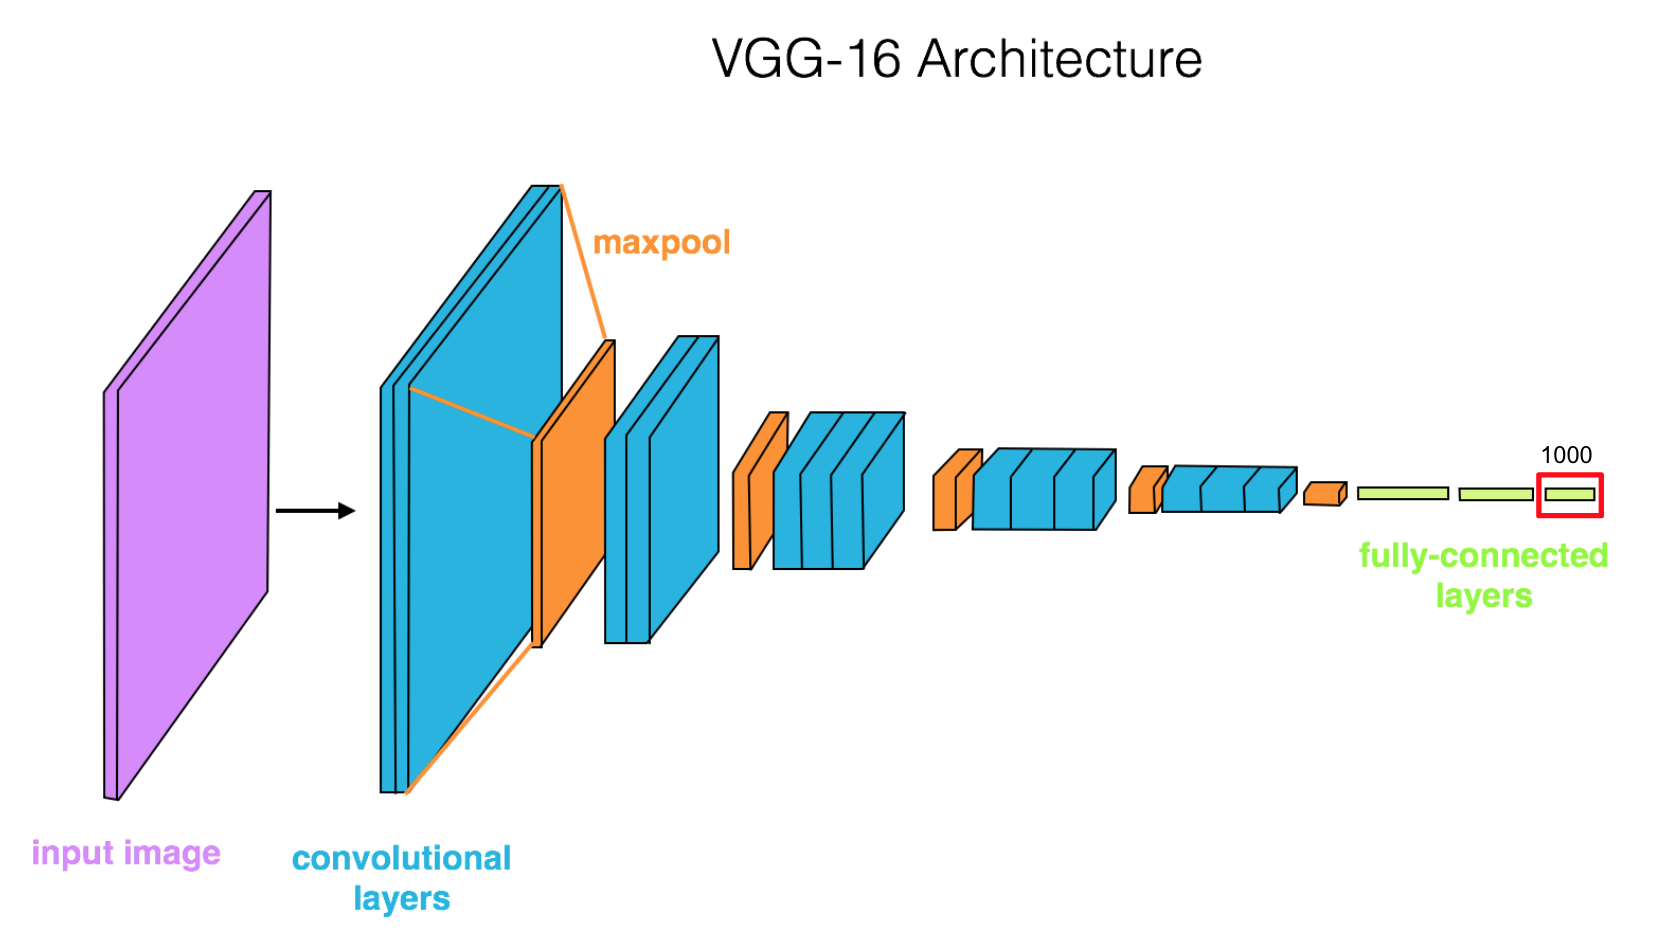

Keep convolutional layers but replace final fully-connected layer with out own classifier. Allows us to use VGGNet as a fixed feature extractor for our images then easily train a simple classifier on top of that
https://cs231n.github.io/transfer-learning/


In [19]:
import os
import numpy as np
import torch

import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt

%matplotlib inline
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is not available.  Training on CPU ...


# PyTorch ImageFolder 
directory path must follow this

root/class_1/xxx.png

root/class_2/xyx.png

In [20]:
# define training and test data directories
data_dir = 'flower_photos/'
train_dir = os.path.join(data_dir, 'train/')
test_dir = os.path.join(data_dir, 'test/')

# classes are folders in each directory with these names
classes = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

# Transforming Data
shape our input data into the shape that the pretrained model expects.

VGG16 expects 224 dim square images as inputs

In [21]:
# VGG-16 Takes 224x224 images as input, so we resize all of them
data_transform = transforms.Compose([transforms.RandomResizedCrop(224), 
                                      transforms.ToTensor()])

train_data = datasets.ImageFolder(train_dir, transform=data_transform)
test_data = datasets.ImageFolder(test_dir, transform=data_transform)

# print out some data stats
print('Num training images: ', len(train_data))
print('Num test images: ', len(test_data))

Num training images:  3130
Num test images:  540


In [22]:
# define dataloader parameters
batch_size = 20
num_workers=0

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
                                          num_workers=num_workers, shuffle=True)

<ipython-input-23-12bd7e90045f>:11: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])


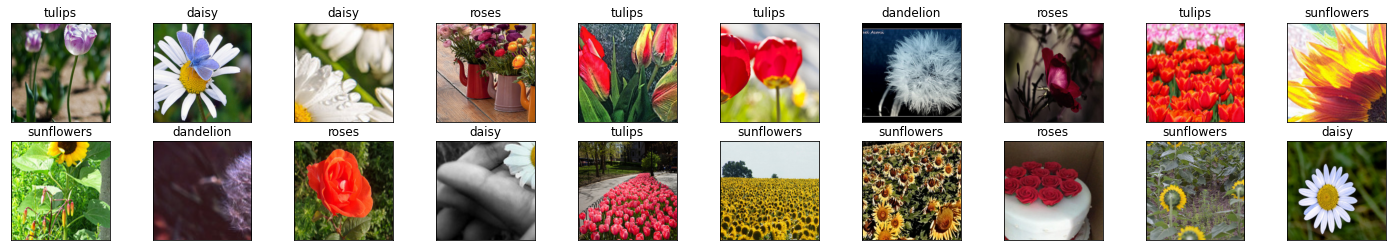

In [23]:
# Visualize some sample data

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])

# Define the Model
To define a model for training we'll follow these steps:

1. Load in a pre-trained VGG16 model
2. "Freeze" all the parameters, so the net acts as a fixed feature extractor
3. Remove the last layer
4. Replace the last layer with a linear classifier of our own
5. Freezing simply means that the parameters in the pre-trained model will not change during training.

In [24]:
vgg16 = models.vgg16(pretrained=True)
vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [25]:
# classification layer is number 6
print(vgg16.classifier[6].in_features)
print(vgg16.classifier[6].out_features)

# Freeze training for all "features" layers
for param in vgg16.features.parameters():
    param.requires_grad = False

4096
1000


# Final Classifier Layer
Replace last layer in the vgg classifier group of layers. This layer should see as input the number of features produced by the portion of the network that you are not changing, and product an appropriate number of outputs for the flower classification task.


In [26]:
import torch.nn as nn

n_inputs = vgg16.classifier[6].in_features

# add last linear layer (n_inputs -> 5 flower classes)
# new layers automatically have requires_grad = True
last_layer = nn.Linear(n_inputs, len(classes))

vgg16.classifier[6] = last_layer

# if GPU is available, move the model to GPU
if train_on_gpu:
    vgg16.cuda()

# check to see that your last layer produces the expected number of outputs
print(vgg16.classifier[6].out_features)
#print(vgg16)

5


In [27]:
# Specify Loss Function and Optimizer
import torch.optim as optim

# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer (stochastic gradient descent) and learning rate = 0.001
optimizer = optim.SGD(vgg16.classifier.parameters(), lr=0.001)


In [28]:
# Training
# number of epochs to train the model
n_epochs = 2

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    
    ###################
    # train the model #
    ###################
    # model by default is set to train
    for batch_i, (data, target) in enumerate(train_loader):
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = vgg16(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss 
        train_loss += loss.item()
        
        if batch_i % 60 == 59:    # print training loss every specified number of mini-batches
            print('Epoch %d, Batch %d loss: %.16f' %
                  (epoch, batch_i + 1, train_loss / 20))
            train_loss = 0.0

Epoch 1, Batch 60 loss: 4.0787965834140776
Epoch 1, Batch 120 loss: 3.2254761576652529
Epoch 2, Batch 60 loss: 2.5840861499309540
Epoch 2, Batch 120 loss: 2.3939466178417206


In [29]:
# track test loss 
# over 5 flower classes
test_loss = 0.0
class_correct = list(0. for i in range(5))
class_total = list(0. for i in range(5))

vgg16.eval() # eval mode

# iterate over test data
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = vgg16(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update  test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate avg test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(5):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))


Test Loss: 0.728860

Test Accuracy of daisy: 65% (60/92)
Test Accuracy of dandelion: 90% (119/132)
Test Accuracy of roses: 69% (63/91)
Test Accuracy of sunflowers: 76% (77/101)
Test Accuracy of tulips: 63% (79/124)

Test Accuracy (Overall): 73% (398/540)


<ipython-input-30-b8af584f7942>:19: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])


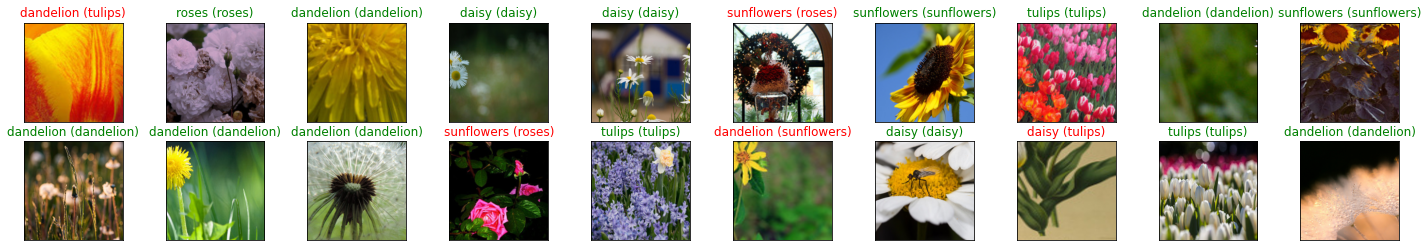

In [30]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

# move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.cuda()

# get sample outputs
output = vgg16(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))